# CIFAR 100 Class Name Image Classification

The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes, with 600 images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). There are 50000 training images and 10000 test images.
The meta file contains the label names of each class and superclass.

**Acknowledgements**

Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009. [Link](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)

## Library

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing


## Download Dataset

Data source from kaggle.com : https://www.kaggle.com/datasets/fedesoriano/cifar100?select=file.txt

### About Dataset

**Content**

Here is the list of the 100 classes in the CIFAR-100:

Classes:
- 1-5) beaver, dolphin, otter, seal, whale
- 6-10) aquarium fish, flatfish, ray, shark, trout
- 11-15) orchids, poppies, roses, sunflowers, tulips
- 16-20) bottles, bowls, cans, cups, plates
- 21-25) apples, mushrooms, oranges, pears, sweet peppers
- 26-30) clock, computer keyboard, lamp, telephone, television
- 31-35) bed, chair, couch, table, wardrobe
- 36-40) bee, beetle, butterfly, caterpillar, cockroach
- 41-45) bear, leopard, lion, tiger, wolf
- 46-50) bridge, castle, house, road, skyscraper
- 51-55) cloud, forest, mountain, plain, sea
- 56-60) camel, cattle, chimpanzee, elephant, kangaroo
- 61-65) fox, porcupine, possum, raccoon, skunk
- 66-70) crab, lobster, snail, spider, worm
- 71-75) baby, boy, girl, man, woman
- 76-80) crocodile, dinosaur, lizard, snake, turtle
- 81-85) hamster, mouse, rabbit, shrew, squirrel
- 86-90) maple, oak, palm, pine, willow
- 91-95) bicycle, bus, motorcycle, pickup truck, train
- 96-100) lawn-mower, rocket, streetcar, tank, tractor

and the list of the 20 superclasses:
- 1) aquatic mammals (classes 1-5)
- 2) fish (classes 6-10)
- 3) flowers (classes 11-15)
- 4) food containers (classes 16-20)
- 5) fruit and vegetables (classes 21-25)
- 6) household electrical devices (classes 26-30)
- 7) household furniture (classes 31-35)
- 8) insects (classes 36-40)
- 9) large carnivores (classes 41-45)
- 10) large man-made outdoor things (classes 46-50)
- 11) large natural outdoor scenes (classes 51-55)
- 12) large omnivores and herbivores (classes 56-60)
- 13) medium-sized mammals (classes 61-65)
- 14) non-insect invertebrates (classes 66-70)
- 15) people (classes 71-75)
- 16) reptiles (classes 76-80)
- 17) small mammals (classes 81-85)
- 18) trees (classes 86-90)
- 19) vehicles 1 (classes 91-95)
- 20) vehicles 2 (classes 96-100)

In [5]:
#load adast
! pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d fedesoriano/cifar100
!unzip cifar100.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes
 90% 145M/161M [00:01<00:00, 133MB/s]
100% 161M/161M [00:01<00:00, 118MB/s]
Archive:  cifar100.zip
  inflating: file.txt                
  inflating: meta                    
  inflating: test                    
  inflating: train                   


In [6]:
# open the download dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
# Meta data path
metadata_path = '/content/meta' 

#Load the metadata
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

## Split Dataset

In [8]:
# File paths
data_train_path = '/content/train'
data_test_path = '/content/test'
data_meta_path = '/content/meta'

# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
meta_data_dict = unpickle(data_meta_path)

# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'fine_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'fine_labels'])

# Get the train dataset
X_train = data_train_dict[b'data']
y_train=label_train

#split the train dataset into train and valid data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

# Reshpe and transpose the data train into image data shape
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
X_valid = X_valid.reshape(len(X_valid),3,32,32).transpose(0,2,3,1)

# Nornalize the data
X_train_1 = X_train/255.
X_valid_1 = X_valid/255.

#transforming the testing dataset
X_test = data_test_dict[b'data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
y_test = label_test


In [9]:
# Check the data shape
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000,),
 (10000, 32, 32, 3),
 (10000,),
 (10000, 32, 32, 3),
 (10000,))

In [10]:
# Check the data counts for each class label
pd.Series(data_train_dict[b'fine_labels']).value_counts()

19    500
69    500
88    500
32    500
34    500
     ... 
81    500
22    500
21    500
65    500
16    500
Length: 100, dtype: int64

In [11]:
# Display table maximum row into 110 row
pd.set_option('display.max_rows', 110)

# 100 category data name
sub_category = pd.DataFrame(metadata[b'fine_label_names'], columns = ['Sub_category'])
sub_df  = sub_category.stack().str.decode('utf-8').unstack()
sub_df

,Sub_category
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
5,bed
6,bee
7,beetle
8,bicycle
9,bottle


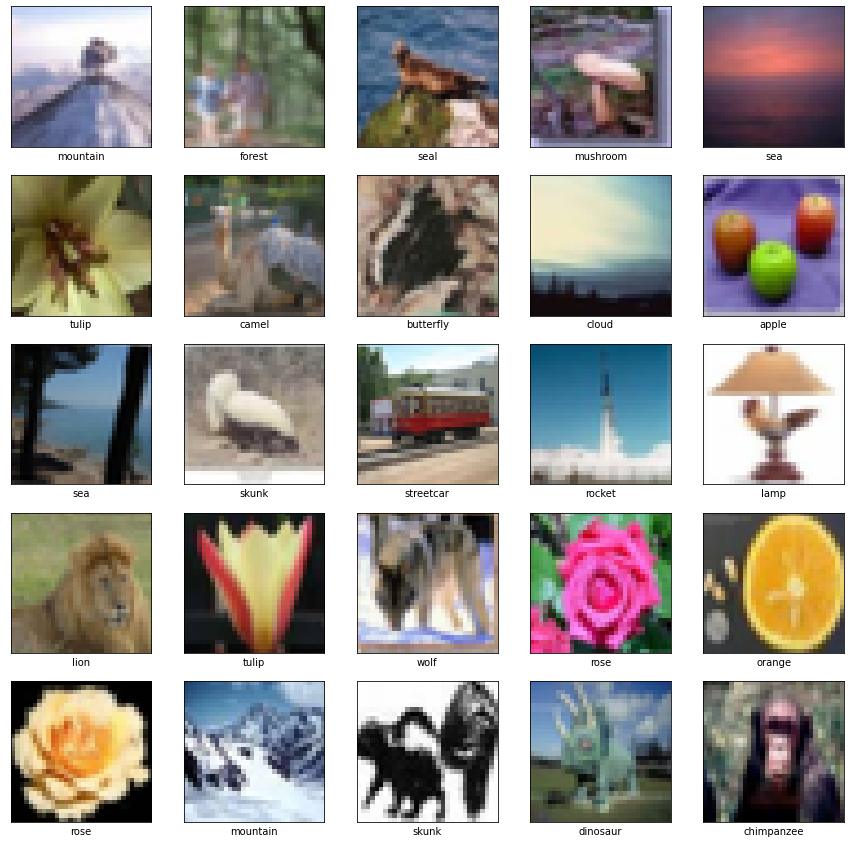

In [12]:
# Show 25 image in the test dataset
plt.figure(figsize=(15,15))
for image in range(0,25):
    i=image
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=i+0
    data_plot = X_test[j]
    plt.imshow(data_plot)
    plt.xlabel(str(sub_df['Sub_category'][y_test[j]]))
plt.show()

In [13]:
# Convert labels to one hot encoding matrix
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

## Augmented with TFDS

In [15]:
#create a data augmentation stage with horizontal flipping, rotations, zooms
train_data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.15),
    preprocessing.RandomZoom(0.15),
    preprocessing.RandomHeight(0.15),
    preprocessing.RandomWidth(0.15),
], name="data_augmentation")

# Create tensorflow dataset, slice the X and y for train dataset and valid dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_1, y_train)) .batch(32).prefetch(tf.data.AUTOTUNE)

valid_data = tf.data.Dataset.from_tensor_slices((X_valid_1, y_valid)).batch(32).prefetch(tf.data.AUTOTUNE)

## Neural Network without Transfer Learning

In [16]:
#Create base mode using Sequential API
base_model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
])

# Define the input shape
inputs = layers.Input(shape=(32, 32, 3), name="input_layer") # shape of input image
x = base_model(inputs)
outputs = layers.Dense(100, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_1 = tf.keras.Model(inputs, outputs)

#model compile
model_1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(lr = 0.001), 
              metrics = ['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# Model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 128)               1405600   
                                                                 
 output_layer (Dense)        (None, 100)               12900     
                                                                 
Total params: 1,418,500
Trainable params: 1,416,580
Non-trainable params: 1,920
_________________________________________________________________


In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=5) #if val loss decrease for 5 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "model_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduce callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, #multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=3,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [19]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                      epochs = 100,
                      validation_data=valid_data,
                      callbacks=[model_checkpoint, # save only the best model during training
                                 early_stopping, # stop model after X epochs of no improvements
                                 reduce_lr]) # reduce the learning rate after X epochs of no improvements)

Epoch 1/100
1244/1250 [============================>.] - ETA: 0s - loss: 4.3025 - accuracy: 0.0687

1250/1250 [==============================] - 30s 14ms/step - loss: 4.3015 - accuracy: 0.0689 - val_loss: 3.5988 - val_accuracy: 0.1501 - lr: 0.0010
Epoch 2/100
1246/1250 [============================>.] - ETA: 0s - loss: 3.6194 - accuracy: 0.1438

1250/1250 [==============================] - 15s 12ms/step - loss: 3.6195 - accuracy: 0.1438 - val_loss: 3.1543 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 3/100
1245/1250 [============================>.] - ETA: 0s - loss: 3.2889 - accuracy: 0.1944

1250/1250 [==============================] - 14s 12ms/step - loss: 3.2898 - accuracy: 0.1942 - val_loss: 2.8945 - val_accuracy: 0.2635 - lr: 0.0010
Epoch 4/100
1248/1250 [============================>.] - ETA: 0s - loss: 3.0236 - accuracy: 0.2423

1250/1250 [==============================] - 14s 11ms/step - loss: 3.0241 - accuracy: 0.2423 - val_loss: 2.5665 - val_accuracy: 0.3271 - lr: 0.0010
Epoch 5/100
1247/1250 [============================>.] - ETA: 0s - loss: 2.8278 - accuracy: 0.2772

1250/1250 [==============================] - 14s 11ms/step - loss: 2.8280 - accuracy: 0.2771 - val_loss: 2.5411 - val_accuracy: 0.3332 - lr: 0.0010
Epoch 6/100
1249/1250 [============================>.] - ETA: 0s - loss: 2.6954 - accuracy: 0.3029

1250/1250 [==============================] - 15s 12ms/step - loss: 2.6959 - accuracy: 0.3028 - val_loss: 2.3495 - val_accuracy: 0.3730 - lr: 0.0010
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 2.5938 - accuracy: 0.3239 - val_loss: 2.3705 - val_accuracy: 0.3748 - lr: 0.0010
Epoch 8/100
1248/1250 [============================>.] - ETA: 0s - loss: 2.4918 - accuracy: 0.3442

1250/1250 [==============================] - 14s 11ms/step - loss: 2.4925 - accuracy: 0.3440 - val_loss: 2.1614 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 9/100
1249/1250 [============================>.] - ETA: 0s - loss: 2.4193 - accuracy: 0.3591

1250/1250 [==============================] - 15s 12ms/step - loss: 2.4197 - accuracy: 0.3591 - val_loss: 2.1546 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 10/100
1246/1250 [============================>.] - ETA: 0s - loss: 2.3516 - accuracy: 0.3773

1250/1250 [==============================] - 15s 12ms/step - loss: 2.3517 - accuracy: 0.3771 - val_loss: 2.1481 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 11/100
1248/1250 [============================>.] - ETA: 0s - loss: 2.2767 - accuracy: 0.3895

1250/1250 [==============================] - 14s 12ms/step - loss: 2.2773 - accuracy: 0.3895 - val_loss: 2.0367 - val_accuracy: 0.4483 - lr: 0.0010
Epoch 12/100
1247/1250 [============================>.] - ETA: 0s - loss: 2.2356 - accuracy: 0.3961

1250/1250 [==============================] - 14s 11ms/step - loss: 2.2355 - accuracy: 0.3961 - val_loss: 1.9946 - val_accuracy: 0.4520 - lr: 0.0010
Epoch 13/100
1250/1250 [==============================] - 10s 8ms/step - loss: 2.1865 - accuracy: 0.4096 - val_loss: 2.0374 - val_accuracy: 0.4428 - lr: 0.0010
Epoch 14/100
1246/1250 [============================>.] - ETA: 0s - loss: 2.1386 - accuracy: 0.4203

1250/1250 [==============================] - 14s 11ms/step - loss: 2.1395 - accuracy: 0.4200 - val_loss: 1.9834 - val_accuracy: 0.4642 - lr: 0.0010
Epoch 15/100
1249/1250 [============================>.] - ETA: 0s - loss: 2.0954 - accuracy: 0.4284

1250/1250 [==============================] - 14s 11ms/step - loss: 2.0958 - accuracy: 0.4284 - val_loss: 1.9018 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 16/100
1250/1250 [==============================] - 10s 8ms/step - loss: 2.0560 - accuracy: 0.4364 - val_loss: 1.9025 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 17/100
1247/1250 [============================>.] - ETA: 0s - loss: 2.0226 - accuracy: 0.4450

1250/1250 [==============================] - 14s 11ms/step - loss: 2.0232 - accuracy: 0.4448 - val_loss: 1.8492 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 18/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9866 - accuracy: 0.4511 - val_loss: 1.8559 - val_accuracy: 0.4859 - lr: 0.0010
Epoch 19/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.9566 - accuracy: 0.4589

1250/1250 [==============================] - 14s 11ms/step - loss: 1.9569 - accuracy: 0.4588 - val_loss: 1.8127 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 20/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9407 - accuracy: 0.4657 - val_loss: 1.8305 - val_accuracy: 0.4980 - lr: 0.0010
Epoch 21/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9061 - accuracy: 0.4717 - val_loss: 1.8158 - val_accuracy: 0.5009 - lr: 0.0010
Epoch 22/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.8831 - accuracy: 0.4748
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1250/1250 [==============================] - 10s 8ms/step - loss: 1.8835 - accuracy: 0.4748 - val_loss: 1.9160 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 23/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.7417 - accuracy: 0.5082

1250/1250 [==============================] - 14s 11ms/step - loss: 1.7423 - accuracy: 0.5080 - val_loss: 1.6809 - val_accuracy: 0.5313 - lr: 2.0000e-04
Epoch 24/100
1247/1250 [============================>.] - ETA: 0s - loss: 1.6956 - accuracy: 0.5198

1250/1250 [==============================] - 15s 12ms/step - loss: 1.6960 - accuracy: 0.5197 - val_loss: 1.6697 - val_accuracy: 0.5359 - lr: 2.0000e-04
Epoch 25/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.6621 - accuracy: 0.5274

1250/1250 [==============================] - 14s 11ms/step - loss: 1.6623 - accuracy: 0.5274 - val_loss: 1.6659 - val_accuracy: 0.5364 - lr: 2.0000e-04
Epoch 26/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.6469 - accuracy: 0.5284

1250/1250 [==============================] - 14s 11ms/step - loss: 1.6470 - accuracy: 0.5282 - val_loss: 1.6505 - val_accuracy: 0.5417 - lr: 2.0000e-04
Epoch 27/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6419 - accuracy: 0.5325 - val_loss: 1.6597 - val_accuracy: 0.5384 - lr: 2.0000e-04
Epoch 28/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.6130 - accuracy: 0.5371 - val_loss: 1.6673 - val_accuracy: 0.5383 - lr: 2.0000e-04
Epoch 29/100
1250/1250 [==============================] - ETA: 0s - loss: 1.6044 - accuracy: 0.5423

1250/1250 [==============================] - 14s 11ms/step - loss: 1.6044 - accuracy: 0.5423 - val_loss: 1.6463 - val_accuracy: 0.5420 - lr: 2.0000e-04
Epoch 30/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5843 - accuracy: 0.5444

1250/1250 [==============================] - 14s 11ms/step - loss: 1.5843 - accuracy: 0.5444 - val_loss: 1.6419 - val_accuracy: 0.5449 - lr: 2.0000e-04
Epoch 31/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5791 - accuracy: 0.5473

1250/1250 [==============================] - 14s 11ms/step - loss: 1.5791 - accuracy: 0.5473 - val_loss: 1.6351 - val_accuracy: 0.5472 - lr: 2.0000e-04
Epoch 32/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5589 - accuracy: 0.5519 - val_loss: 1.6362 - val_accuracy: 0.5497 - lr: 2.0000e-04
Epoch 33/100
1246/1250 [============================>.] - ETA: 0s - loss: 1.5539 - accuracy: 0.5492

1250/1250 [==============================] - 14s 11ms/step - loss: 1.5545 - accuracy: 0.5489 - val_loss: 1.6287 - val_accuracy: 0.5500 - lr: 2.0000e-04
Epoch 34/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.5544 - accuracy: 0.5505 - val_loss: 1.6390 - val_accuracy: 0.5499 - lr: 2.0000e-04
Epoch 35/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5306 - accuracy: 0.5563 - val_loss: 1.6293 - val_accuracy: 0.5485 - lr: 2.0000e-04
Epoch 36/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5284 - accuracy: 0.5595

1250/1250 [==============================] - 14s 11ms/step - loss: 1.5284 - accuracy: 0.5595 - val_loss: 1.6273 - val_accuracy: 0.5517 - lr: 2.0000e-04
Epoch 37/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5218 - accuracy: 0.5597 - val_loss: 1.6394 - val_accuracy: 0.5464 - lr: 2.0000e-04
Epoch 38/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.5118 - accuracy: 0.5618

1250/1250 [==============================] - 14s 11ms/step - loss: 1.5122 - accuracy: 0.5617 - val_loss: 1.6237 - val_accuracy: 0.5529 - lr: 2.0000e-04
Epoch 39/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.5104 - accuracy: 0.5634

1250/1250 [==============================] - 14s 11ms/step - loss: 1.5109 - accuracy: 0.5633 - val_loss: 1.6135 - val_accuracy: 0.5533 - lr: 2.0000e-04
Epoch 40/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.5000 - accuracy: 0.5644 - val_loss: 1.6218 - val_accuracy: 0.5537 - lr: 2.0000e-04
Epoch 41/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4915 - accuracy: 0.5674 - val_loss: 1.6201 - val_accuracy: 0.5546 - lr: 2.0000e-04
Epoch 42/100
1246/1250 [============================>.] - ETA: 0s - loss: 1.4931 - accuracy: 0.5660
Epoch 42: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4930 - accuracy: 0.5660 - val_loss: 1.6228 - val_accuracy: 0.5536 - lr: 2.0000e-04
Epoch 43/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.4625 - accuracy: 0.5736

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4629 - accuracy: 0.5735 - val_loss: 1.6063 - val_accuracy: 0.5574 - lr: 4.0000e-05
Epoch 44/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.4521 - accuracy: 0.5752

1250/1250 [==============================] - 14s 12ms/step - loss: 1.4524 - accuracy: 0.5752 - val_loss: 1.6041 - val_accuracy: 0.5575 - lr: 4.0000e-05
Epoch 45/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.4466 - accuracy: 0.5786

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4468 - accuracy: 0.5785 - val_loss: 1.6004 - val_accuracy: 0.5596 - lr: 4.0000e-05
Epoch 46/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.4394 - accuracy: 0.5792 - val_loss: 1.6028 - val_accuracy: 0.5578 - lr: 4.0000e-05
Epoch 47/100
1244/1250 [============================>.] - ETA: 0s - loss: 1.4388 - accuracy: 0.5802

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4390 - accuracy: 0.5801 - val_loss: 1.5975 - val_accuracy: 0.5601 - lr: 4.0000e-05
Epoch 48/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4365 - accuracy: 0.5818 - val_loss: 1.5992 - val_accuracy: 0.5599 - lr: 4.0000e-05
Epoch 49/100
1243/1250 [============================>.] - ETA: 0s - loss: 1.4286 - accuracy: 0.5834

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4294 - accuracy: 0.5832 - val_loss: 1.5972 - val_accuracy: 0.5599 - lr: 4.0000e-05
Epoch 50/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4319 - accuracy: 0.5848 - val_loss: 1.5978 - val_accuracy: 0.5588 - lr: 4.0000e-05
Epoch 51/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4251 - accuracy: 0.5843 - val_loss: 1.5984 - val_accuracy: 0.5606 - lr: 4.0000e-05
Epoch 52/100
1247/1250 [============================>.] - ETA: 0s - loss: 1.4259 - accuracy: 0.5836
Epoch 52: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4265 - accuracy: 0.5835 - val_loss: 1.5982 - val_accuracy: 0.5591 - lr: 4.0000e-05
Epoch 53/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4092 - accuracy: 0.5851 - val_loss: 1.5975 - val_accuracy: 0.5589 - lr: 8.0000e-06
Epoch 54/100
1246/1250 [====

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4139 - accuracy: 0.5856 - val_loss: 1.5971 - val_accuracy: 0.5601 - lr: 8.0000e-06
Epoch 55/100
1250/1250 [==============================] - ETA: 0s - loss: 1.4174 - accuracy: 0.5833

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4174 - accuracy: 0.5833 - val_loss: 1.5970 - val_accuracy: 0.5603 - lr: 8.0000e-06
Epoch 56/100
1245/1250 [============================>.] - ETA: 0s - loss: 1.4192 - accuracy: 0.5853

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4198 - accuracy: 0.5851 - val_loss: 1.5959 - val_accuracy: 0.5611 - lr: 8.0000e-06
Epoch 57/100
1249/1250 [============================>.] - ETA: 0s - loss: 1.4176 - accuracy: 0.5871

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4181 - accuracy: 0.5871 - val_loss: 1.5953 - val_accuracy: 0.5583 - lr: 8.0000e-06
Epoch 58/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4132 - accuracy: 0.5874 - val_loss: 1.5957 - val_accuracy: 0.5594 - lr: 8.0000e-06
Epoch 59/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4176 - accuracy: 0.5862 - val_loss: 1.5953 - val_accuracy: 0.5601 - lr: 8.0000e-06
Epoch 60/100
1244/1250 [============================>.] - ETA: 0s - loss: 1.4204 - accuracy: 0.5818
Epoch 60: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4209 - accuracy: 0.5818 - val_loss: 1.5956 - val_accuracy: 0.5603 - lr: 8.0000e-06
Epoch 61/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4180 - accuracy: 0.5865 - val_loss: 1.5955 - val_accuracy: 0.5601 - lr: 1.6000e-06
Epoch 62/100
1246/1250 [===

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4131 - accuracy: 0.5843 - val_loss: 1.5952 - val_accuracy: 0.5606 - lr: 1.6000e-06
Epoch 63/100
1246/1250 [============================>.] - ETA: 0s - loss: 1.4049 - accuracy: 0.5871

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4054 - accuracy: 0.5870 - val_loss: 1.5951 - val_accuracy: 0.5604 - lr: 1.6000e-06
Epoch 64/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4106 - accuracy: 0.5848 - val_loss: 1.5957 - val_accuracy: 0.5603 - lr: 1.6000e-06
Epoch 65/100
1248/1250 [============================>.] - ETA: 0s - loss: 1.4139 - accuracy: 0.5853
Epoch 65: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4143 - accuracy: 0.5851 - val_loss: 1.5955 - val_accuracy: 0.5604 - lr: 1.6000e-06
Epoch 66/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4179 - accuracy: 0.5866 - val_loss: 1.5952 - val_accuracy: 0.5603 - lr: 3.2000e-07
Epoch 67/100
1244/1250 [============================>.] - ETA: 0s - loss: 1.4094 - accuracy: 0.5866

1250/1250 [==============================] - 14s 11ms/step - loss: 1.4100 - accuracy: 0.5863 - val_loss: 1.5949 - val_accuracy: 0.5596 - lr: 3.2000e-07
Epoch 68/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4063 - accuracy: 0.5877 - val_loss: 1.5953 - val_accuracy: 0.5605 - lr: 3.2000e-07
Epoch 69/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4157 - accuracy: 0.5850 - val_loss: 1.5960 - val_accuracy: 0.5602 - lr: 3.2000e-07
Epoch 70/100
1245/1250 [============================>.] - ETA: 0s - loss: 1.4235 - accuracy: 0.5839
Epoch 70: ReduceLROnPlateau reducing learning rate to 1e-07.
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4242 - accuracy: 0.5839 - val_loss: 1.5951 - val_accuracy: 0.5601 - lr: 3.2000e-07
Epoch 71/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.4137 - accuracy: 0.5871 - val_loss: 1.5959 - val_accuracy: 0.5602 - lr: 1.0000e-07
Epoch 72/100
1250/1250 [====================

In [20]:
#plot history

def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.figure()

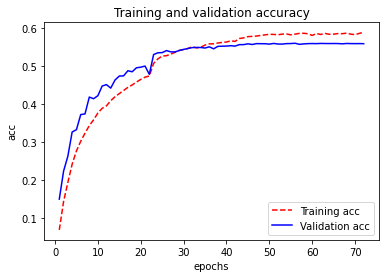

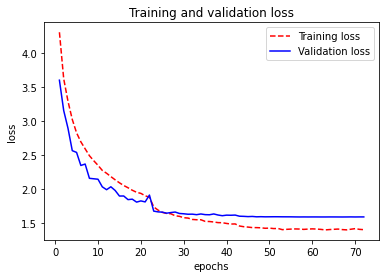

<Figure size 432x288 with 0 Axes>

In [21]:
plot_history(history_1)

## Evaluate Model Performance

In [22]:
# Evaluate model for valid_dataset
model__evaluate = model_1.evaluate(valid_data)

313/313 [==============================] - 1s 4ms/step - loss: 1.5958 - accuracy: 0.5599


In [23]:
# Evaluate model for X_test and y_test
X_test_1 = (X_test/255.)
model_1_evaluate_test = model_1.evaluate(X_test_1, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.5946 - accuracy: 0.5663


In [24]:
# Create true label and predict label dataframe

test_label = y_test.argmax(axis=1) # label in test dataset
predict_label = model_1.predict(X_test_1).argmax(axis=1) # Predict the test data


label_name =  [] 
predict_name = []
for i in range(0,10000):
  tlab = sub_df['Sub_category'][test_label.tolist()[i]]
  label_name.append(tlab)

  plab = sub_df['Sub_category'][predict_label.tolist()[i]]
  predict_name.append(plab)


test_predict = pd.DataFrame({"label_num": test_label, 
                    "label_name": label_name,
                    "predict_num" : predict_label,
                    "predict_name" : predict_name})
test_predict

313/313 [==============================] - 2s 4ms/step


,label_num,label_name,predict_num,predict_name
0,49,mountain,90,train
1,33,forest,80,squirrel
2,72,seal,30,dolphin
3,51,mushroom,51,mushroom
4,71,sea,71,sea
...,...,...,...,...
9995,83,sweet_pepper,83,sweet_pepper
9996,14,butterfly,63,porcupine
9997,51,mushroom,51,mushroom
9998,42,leopard,42,leopard


In [27]:
# Confusion matrix for true label and predict label
cm = confusion_matrix(test_predict["label_name"], test_predict["predict_name"])
n_classes = cm.shape[0] # 100 number classes

#create confution matrix plot
fig, ax = plt.subplots(figsize=(150,150))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

labels = sub_df["Sub_category"].tolist()
# labels, title and ticks
ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(0.5, n_classes+0.5), # create enough axis slots for each class
         yticks=np.arange(0.5, n_classes+0.5), 
         xticklabels= labels, # axes will labeled with class names (if they exist) or ints
       )
ax.set_xticklabels(labels, ha="center", rotation=90)
ax.set_yticklabels(labels, va="center", rotation=0);

In [28]:
# Classification report for true label and predict label
print(classification_report(test_predict["label_name"], test_predict["predict_name"]))

               precision    recall  f1-score   support

        apple       0.75      0.84      0.79       100
aquarium_fish       0.72      0.66      0.69       100
         baby       0.38      0.40      0.39       100
         bear       0.36      0.24      0.29       100
       beaver       0.25      0.30      0.27       100
          bed       0.49      0.63      0.55       100
          bee       0.57      0.70      0.63       100
       beetle       0.65      0.49      0.56       100
      bicycle       0.71      0.73      0.72       100
       bottle       0.69      0.75      0.72       100
         bowl       0.49      0.44      0.46       100
          boy       0.47      0.37      0.41       100
       bridge       0.57      0.60      0.59       100
          bus       0.47      0.37      0.41       100
    butterfly       0.62      0.40      0.49       100
        camel       0.49      0.42      0.45       100
          can       0.60      0.60      0.60       100
       ca

In [46]:
label = sub_df["Sub_category"].tolist() # Collect the class name as a list

# Calculate the F1-score for each label name
f1_scores = f1_score(test_predict["label_name"], test_predict["predict_name"], average=None, labels=labels)
f1_scores_with_labels = {label:score for label,score in zip(labels, f1_scores)}

#Create F1-score dataframe for each label name
f1_score_table = pd.DataFrame(list(f1_scores_with_labels.items()), columns=["Class", "F1-Score"])
f1_score_table = f1_score_table.sort_values(by="F1-Score", ascending=False).reset_index(drop=True) # Sore dataframe by F1-score value
f1_score_table

,Class,F1-Score
0,road,0.872549
1,sunflower,0.861538
2,wardrobe,0.837438
3,motorcycle,0.834862
4,plain,0.828571
5,orange,0.809302
6,chair,0.801980
7,apple,0.792453
8,palm_tree,0.787565
9,skunk,0.783069


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


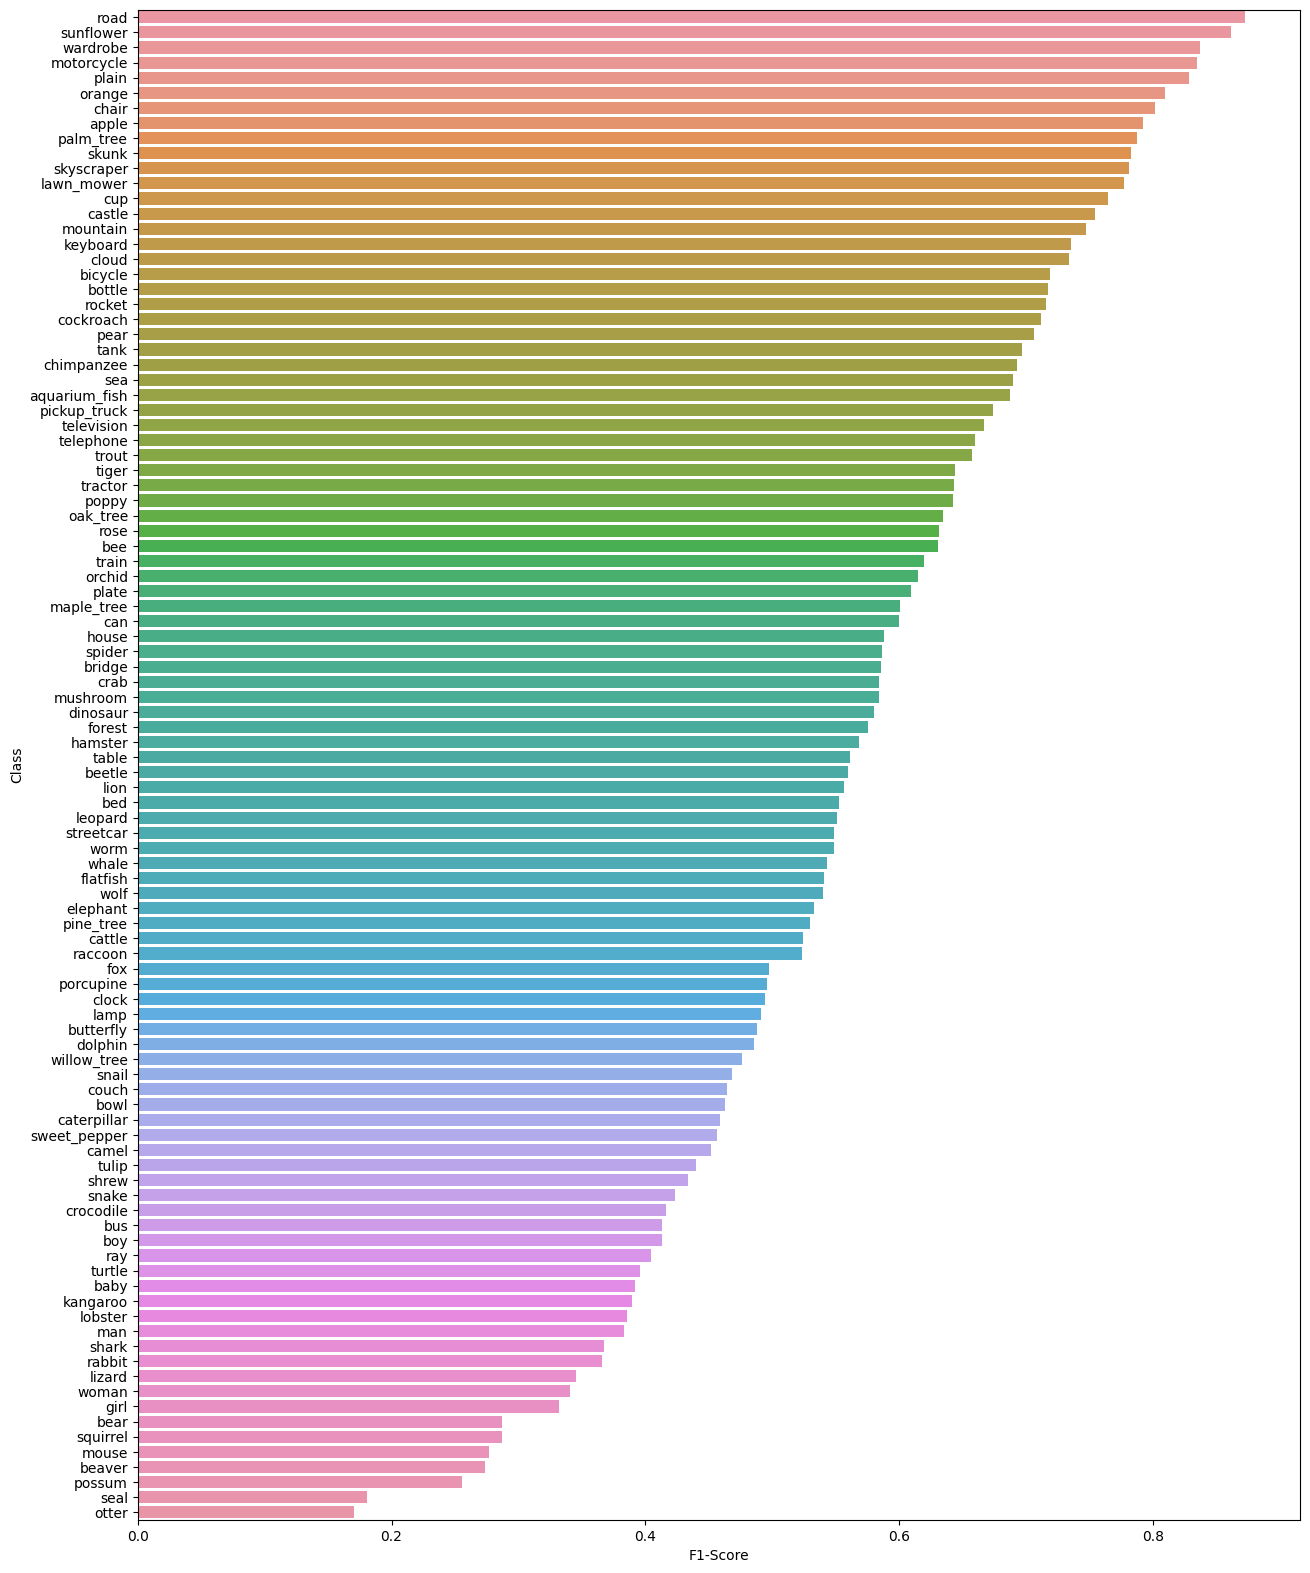

In [58]:
# Barplot for f1score dataframe
plt.figure(figsize=(15,20), dpi=100)
sns.barplot(f1_score_table["F1-Score"], f1_score_table["Class"]);

In [63]:
# Create check label
test_predict["correct_check"] = test_predict["label_num"] == test_predict["predict_num"]

# Create predict probability column
test_predict["pred_conf"] = pred_prob = model_1.predict(X_test).max(axis=1)
test_predict.head()

313/313 [==============================] - 1s 3ms/step


,label_num,label_name,predict_num,predict_name,correct_check,pred_conf
0,49,mountain,90,train,False,1.000000
1,33,forest,80,squirrel,False,1.000000
2,72,seal,30,dolphin,False,1.000000
3,51,mushroom,51,mushroom,True,1.000000
4,71,sea,71,sea,True,0.999806


## The Most Wrong Prediction

In [64]:
# Get the top 100 wrong examples
top_100_wrong = test_predict[test_predict["correct_check"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,label_num,label_name,predict_num,predict_name,correct_check,pred_conf
0,49,mountain,90,train,False,1.0
5909,73,shark,30,dolphin,False,1.0
5915,19,cattle,43,lion,False,1.0
5920,13,bus,81,streetcar,False,1.0
5922,67,ray,1,aquarium_fish,False,1.0
5927,76,skyscraper,71,sea,False,1.0
5933,55,otter,21,chimpanzee,False,1.0
5936,46,man,40,lamp,False,1.0
5941,71,sea,60,plain,False,1.0
5943,6,bee,82,sunflower,False,1.0


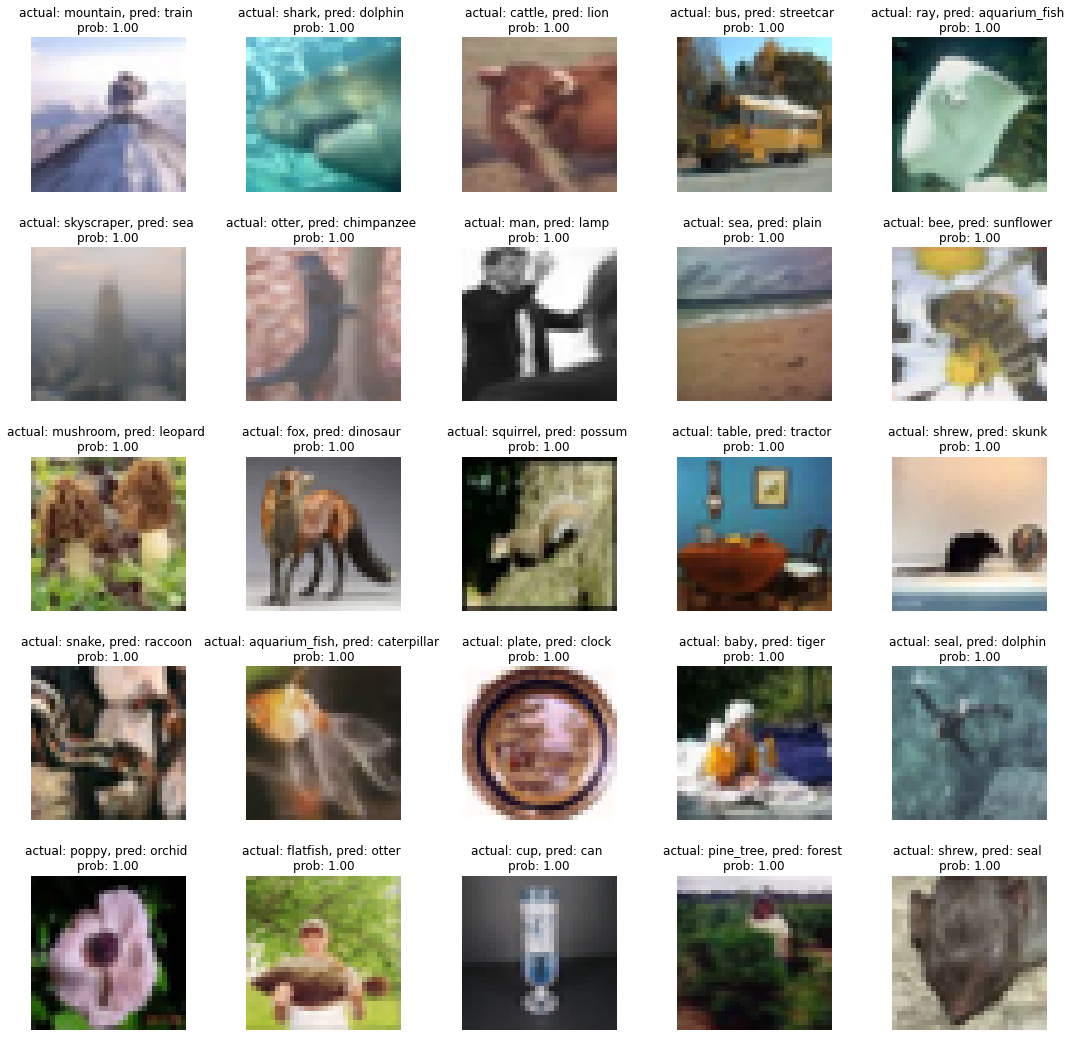

In [86]:
# Visualize some of the most wrong examples
plt.figure(figsize=(15, 15))
for i, row in enumerate(top_100_wrong[:25].itertuples()): 
  plt.subplot(5, 5, i+1)
  data_plot = X_test[row[0]]
  _,_, label_name, _, predict_name, _, pred_conf= row #only define feature thet we need
  plt.imshow(data_plot)
  plt.title(f"actual: {label_name}, pred: {predict_name} \nprob: {pred_conf:.2f}")
  plt.tight_layout()
  plt.axis(False)

## Save the model

In [88]:
#save model
model_1.save("CIFAR100_TFDS_model.h5")